# Setup

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from sklearn.metrics import roc_auc_score
from torch_geometric import seed_everything
from tqdm import tqdm
from collections import defaultdict


sys.path.append("../../..")
from src.models import final_model, prediction_utils, training_utils

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/node_eval/final_eval/"
figs_folder = "../../../reports/figs_p_tesis/"
models_folder = "../../../models/final_model/"

seed = 4
seed_everything(4)
sns.set_theme()
sns.set_context("paper")

prediction_mode = False

Cargo los datos y pesos del modelo, genero los encodings para hacer predicciones

In [222]:
node_df = pd.read_csv(data_folder + f"seed_{seed}/tensor_df.csv", index_col=0).set_index("node_index", drop=True)
dataset, node_map = training_utils.load_data(data_folder + f"seed_{seed}/", load_test=True)
test_data = dataset[2]

# Armo los dataframes con la referencia de qué enlaces se usaron para propagar
mapped_dataset = prediction_utils.MappedDataset(test_data, node_map, ("gene_protein", "gda", "disease"))
mapped_df = mapped_dataset.dataframe
mapped_df = mapped_df.rename(columns={x: x.replace("_source", "").replace("_target", "") for x in mapped_df.columns})

#si solo voy a cargar los resultados no necesito ocupar memoria con esto
if prediction_mode:
# load data
    with open(f"{models_folder}training_parameters.pickle", "rb") as handle:
        params = pickle.load(handle)

    # initialize features in test data
    test_data = training_utils.initialize_features(test_data, params["feature_type"], params["feature_dim"], feature_folder)

    # load model
    weights_path = models_folder + f"seeds/final_model_{seed}.pth"
    weights = torch.load(weights_path)
    model = final_model.Model(test_data.metadata(), [("gene_protein", "gda", "disease")])
    model.load_state_dict(weights)

    encodings_dict = training_utils.get_encodings(model, test_data)
    predictor = prediction_utils.Predictor(node_df, encodings_dict)
else:
    disease_rank_info = pd.read_csv(reports_folder+"rank_info.csv",index_col=0)
    disease_rank_results = pd.read_csv(reports_folder+"rank_results.csv",index_col=0)
    hitrate_df = pd.read_csv(reports_folder+"hitrate_results.csv",index_col=0)
    hitrate_df.columns = hitrate_df.columns.map(int)
    gene_mrr_df = pd.read_csv(reports_folder+"gene_mrr.csv",index_col=0)
    


diseases = node_df[(node_df.node_type == "disease")&(node_df.node_source == "disgenet")]
genes = node_df[(node_df.node_type == "gene_protein")&(node_df.node_source != "signor")].index.values

Separo en enlaces vistos y no vistos. Los enlaces vistos son los que el modelo ya usó en train-val, ya sea como enlaces de propagación o como supervisión. Los no vistos son los enlaces de supervisión que quedaron en el conjunto de test (para este análisis solo me interesan los de etiqueta positiva).

Para simplificar, aprovecho que todos los enlaces de propagación y supervisión de train-val, pasan a ser enlaces de propagación de test. Esto es por el tipo de split que usé (transductivo)

In [3]:
seen_edges = mapped_df[(mapped_df.edge_type == "message_passing")][["gene_protein","disease"]]
new_edges = mapped_df[(mapped_df.edge_type == "supervision") & (mapped_df.label == 1) ][["gene_protein","disease"]]

Cargo los enlaces de la sub-red de enfermedades, porque quiero ver el grado d-d que tienen algunos nodos al evaluar. No puedo verlo directamente del grafo original porque al hacer el split se dividen también los enlaces d-d y el grado que tienen para propagar puede ser diferente.

In [4]:
disgenet_edges = mapped_df[(mapped_df.edge_type == "message_passing") | (mapped_df.label == 1)]
mapped_dd = prediction_utils.MappedDataset(test_data,node_map,("disease","disease_disease","disease"))
mapped_dd_df = mapped_dd.dataframe

diseases_in_dd_propagation = list(set(mapped_dd_df[mapped_dd_df.edge_type == "message_passing"][["disease_source","disease_target"]].values.flatten()))
dd_propagation_degree = pd.DataFrame(mapped_dd_df.set_index("disease_source").loc[diseases_in_dd_propagation].reset_index().disease_source.value_counts()).rename(columns={"disease_source":"degree_dd_prop"})

# Modo 1-vs-all

Ordeno todos los genes del grafo vs una enfermedad (y viceversa para el caso gen->enf).
Tomo todos los genes no asociados como etiquetas negativas, en lugar de solo usar las etiquetas negativas que había generado antes. Hago todas las evaluaciones y después lo separo en casos.

**El problema:**

Si el número de nodos es > 15000, buscar rankear cosas en el top 10 va a ser muuuuy difícil. Me estoy guíando con lo que ví en otros papers y tomando varios rangos, el rango más grande abarca aprox el 10% de los nodos disponibles para ordenar.

Con los rangos que puse estamos viendo en porcentajes el top: 0.05, 0.3%, 0.5%, 1.7%, 2.8%, 5%, 8.6% .

**Hit Rate vs Recall:**

Como recall depende mucho de la cantidad de items para recuperar, evalue en terminos de hit rate. 

El problema con recall es que si, supongamos que me importan los top 10, si un nodo tiene 50 positivos, la cota superior de recall es 0.2.
Tome k hasta 40, para calcular hit rate en ese rango, similar al paper de PGCN pero con un rango más amplio y hit rate en lugar de recall.

**Influencia del grado en el ranking:**

Quiero ver que tanto está molestando esto. La idea es la siguiente: en los rankings de M nodos aleatorios, un nodo de grado alto tiene 1/(num nodos) chances de aparecer. Pero en la lista completa aparece si o si! Si el modelo está priorizando demasiado los nodos de grado alto, va a molestar muchiiiisimo más en este contexto que en el otro.

Para ver esto voy a tratar de medir el MRR vs grado de todos los genes para esta evaluación

In [ ]:
#Separo las enfermedades que tienen datos para evaluar
eval_diseases = new_edges.disease.unique()

#registro el número de labels positivas para predecir que tenia la enfermedad, esto es para después separar en casos
#lo ordeno según eval_diseases 
num_positive_labels = new_edges.disease.value_counts().loc[eval_diseases].values
num_propagation_edges = np.zeros(len(eval_diseases))

#registro en que puesto cae la primer asociación positiva que aparece en el ranking, esto me sirve para calcular varias métricas (incluida hit rate)
first_positive_rank = np.zeros(len(eval_diseases))

#Rangos de evaluación de AUC y top_k
eval_rangos = [10,50,100,300,500,1000,1500,1700]
k_rangos = 50

full_auc_results = np.zeros(len(eval_diseases))
auc_results = np.zeros((len(eval_rangos), len(eval_diseases)))
hitrate_results = np.zeros((k_rangos, len(eval_diseases)))
gene_reciprocal_rank = defaultdict(lambda: {'sum': 0, 'count': 0})

for idx, disease in enumerate(tqdm(eval_diseases)):
    positive_edges = new_edges.loc[(new_edges.disease == disease),"gene_protein"].values

    #sacamos los enlaces de propagación del ranking y registro cuantos eran
    to_remove = seen_edges[seen_edges.disease == disease].gene_protein.values
    num_propagation_edges[idx] = len(to_remove)

    #separo en casos: nodo con enlaces conocidos o nodo "nuevo"
    if len(to_remove) > 0:
        targets = node_df[(node_df.node_type == "gene_protein")&(node_df.node_source != "signor")].drop(to_remove).index.values
        ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease,targets)
    else:
        targets = node_df[(node_df.node_type == "gene_protein")&(node_df.node_source != "signor")].index.values
        ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease,targets)

    # genero una mascara que dice en que indices hay un nodo positivo y registro el primer indice
    label_array = np.in1d(ranked_index, positive_edges)
    first_positive_index = np.nonzero(label_array)[0][0] + 1
    first_positive_rank[idx] = first_positive_index

    # Calculo el Reciprocal Rank de los genes en todas las listas
    reciprocal_rank_dict = {gene.item(): 1/rank for rank, gene in enumerate(ranked_index, start=1)}

    for gene, reciprocal_rank in reciprocal_rank_dict.items():
        gene_reciprocal_rank[gene]['sum'] += reciprocal_rank
        gene_reciprocal_rank[gene]['count'] += 1
    
    #Calculo el AUC total
    full_auc_results[idx] = roc_auc_score(label_array,ranked_scores)

    # Calculo el AUC @k para diferentes valores. Si el primer true positive es un puesto mayor a k, el AUC por definición es 0.
    for i,k in enumerate(eval_rangos):
        k_labels = label_array[:k]
        k_scores = ranked_scores[:k]

        #Si no entró ningun verdadero positivo a la lista el modelo funcionó mal, AUC = 0
        if first_positive_index > k:
            auc_results[i,idx] = 0
        else:
            #Si los top k son todas etiquetas positivas sklearn no puede calcular AUC. 
            #Como el modelo funcionó perfecto en este caso le ponemos AUC = 1
            #Caso contrario, calculamos AUC como siempre
            if all(k_labels):
                auc_results[i,idx] = 1
            else:
                auc_results[i,idx] = roc_auc_score(k_labels,k_scores)

    # Calculo el hitrate @ k
    for k in range(k_rangos):
        if first_positive_index <= k:
            hitrate_results[k,idx] = 1
        else:
            hitrate_results[k,idx] = 0

#Tomo el MRR de los genes que participaron
average_reciprocal_rank = {gene: stats['sum'] / stats['count'] for gene, stats in gene_reciprocal_rank.items()}        

In [ ]:
hitrate_df = pd.DataFrame(hitrate_results.T,index=eval_diseases)
hitrate_df.to_csv(reports_folder+"hitrate_results.csv")

gene_mrr_df = pd.DataFrame.from_dict(average_reciprocal_rank,orient="index",columns=["MRR"])
gene_mrr_df.index.name = "node_index"
gene_mrr_df.to_csv(reports_folder+"gene_mrr.csv")

In [ ]:
disease_rank_info = pd.DataFrame(np.array([num_positive_labels,first_positive_rank,num_propagation_edges]).T, columns = ["num_positive_labels","first_positive_rank","num_propagation_edges"], index=eval_diseases)
disease_rank_info = disease_rank_info.merge(node_df[["node_name","degree_gda","degree_dd"]], left_index=True, right_index=True, how="left")
disease_rank_info = disease_rank_info.merge(dd_propagation_degree, right_index=True,left_index=True, how="left").fillna(0)

disease_rank_results = pd.DataFrame(np.array(auc_results).T, columns = ["auc_"+str(k) for k in eval_rangos], index=eval_diseases)
disease_rank_results["auc_full"] = full_auc_results

disease_rank_info.to_csv(reports_folder+"rank_info.csv")
disease_rank_results.to_csv(reports_folder+"rank_results.csv")

# Análisis de HitRate

Separo en tres casos según niveles de info disponibles para el modelo:

- La curva naranja son las enfermedades con enlaces GDA de propagación.

- Las curvas verde y celeste son enfermedades sin enlaces GDA de propagación.

- La diferencia entre la curva celeste y la verde es que las enfermedades de la curva verde no forman parte de la red D-D: no tienen enlaces enfermedad-enfermedad ni descripción de texto. Las de la curva celeste sí están en la red D-D.


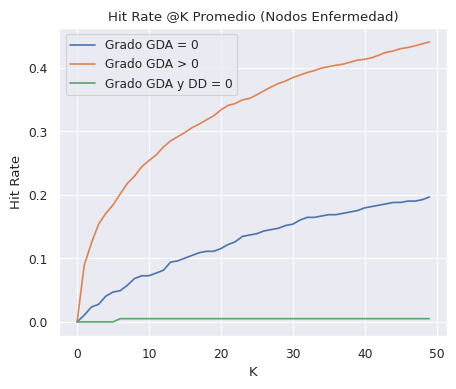

In [24]:
max_range = 50

new_diseases = disease_rank_info[(disease_rank_info.num_propagation_edges == 0)&(disease_rank_info.degree_dd_prop != 0)].index.values
new_diseases_nofeat = disease_rank_info[(disease_rank_info.num_propagation_edges == 0) & (disease_rank_info.degree_dd == 0)].index.values
gda_prop_diseases = disease_rank_info[disease_rank_info.num_propagation_edges != 0].index.values

plt.figure(figsize=(5,4))
plt.plot([*range(max_range)],hitrate_df[[*range(max_range)]].loc[new_diseases].mean().values, label="Grado GDA = 0")
plt.plot([*range(max_range)],hitrate_df[[*range(max_range)]].loc[gda_prop_diseases].mean().values, label="Grado GDA > 0")
plt.plot([*range(max_range)],hitrate_df[[*range(max_range)]].loc[new_diseases_nofeat].mean().values, label="Grado GDA y DD = 0")
plt.title("Hit Rate @K Promedio (Nodos Enfermedad)")
plt.xlabel("K")
plt.ylabel("Hit Rate")
plt.legend()

plt.savefig(figs_folder+"hitrate_curves.png", format="png", dpi=300,bbox_inches='tight')


# Análisis de MRR vs grado de genes

In [223]:
num_propagation_edges = seen_edges.gene_protein.value_counts().rename("num_propagation_edges")
gene_mrr_df = gene_mrr_df.merge(num_propagation_edges, left_index=True,right_index=True,how="left").fillna(0)
gene_mrr_df.sort_values(by="num_propagation_edges")

,MRR,num_propagation_edges
node_index,,
4570,0.000243,0.0
12111,0.000216,0.0
2839,0.000221,0.0
10312,0.000167,0.0
16353,0.000195,0.0
...,...,...
10697,0.003337,216.0
14317,0.002741,219.0
7870,0.001626,250.0


In [224]:
gene_mrr_df["MRR"] = 1/gene_mrr_df["MRR"]

In [116]:
def group_by_size(data_df,bin_col,num_groups,max_log):
    df = data_df.copy()
    spacing = np.linspace(1,max_log,num=num_groups).round().astype(int)
    bins = np.digitize(df[bin_col].values, spacing)
    df["bins"] = bins
    
    mean_s = df.groupby("bins").mean().round(2).rename(columns={old:str(old)+"_mean" for old in df.columns.values})
    std = df.groupby("bins").std().round(2).rename(columns={old:str(old)+"_std" for old in df.columns.values}).fillna(0)

    result = pd.concat([mean_s,std], axis=1)
    return result

/tmp/ipykernel_23975/1712969923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_mrr_df["bins"] = bins


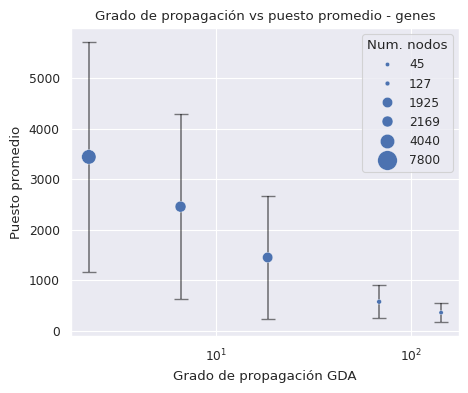

<Figure size 640x480 with 0 Axes>

In [233]:
spacing = [1,5,10,50,100]
bins = np.digitize(gene_mrr_df["num_propagation_edges"].values, spacing)
gene_mrr_df["bins"] = bins

mean_s = gene_mrr_df[["MRR","bins","num_propagation_edges"]].groupby("bins").mean().round(2).rename(columns={old:str(old)+"_mean" for old in gene_mrr_df.columns.values})
std = gene_mrr_df[["MRR","bins"]].groupby("bins").std().round(2).rename(columns={old:str(old)+"_std" for old in gene_mrr_df.columns.values}).fillna(0)
count = gene_mrr_df[["MRR","bins"]].groupby("bins").count().rename(columns={old:"count" for old in gene_mrr_df.columns.values}).fillna(0)
result = pd.concat([mean_s,std,count], axis=1)

plt.figure(figsize=(5,4))
plt.xscale("log")
sns.scatterplot(result, x="num_propagation_edges_mean",y="MRR_mean",size="count",alpha=1,zorder=2,sizes=(10,200))
plt.errorbar(result["num_propagation_edges_mean"], result["MRR_mean"], yerr=result["MRR_std"], fmt=' ', color='black',alpha=0.5, capsize=5,zorder=1)
plt.xlabel("Grado de propagación GDA")
plt.ylabel("Puesto promedio")
plt.title("Grado de propagación vs puesto promedio - genes")
plt.legend(title="Num. nodos")

plt.show()
plt.savefig(figs_folder+"rank_vs_k.png",format="png", dpi=300,bbox_inches='tight')

# Tablas 

In [236]:
disease_rank_results.mean()

auc_10      0.134512
auc_50      0.252410
auc_100     0.318598
auc_300     0.445414
auc_500     0.512418
auc_1000    0.589985
auc_1500    0.627693
auc_1700    0.639312
auc_full    0.832122
dtype: float64